# Load Library

In [2]:
import argparse, os, warnings, torch
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.colors as mcolors
from src.metrics import *

warnings.filterwarnings(action='ignore')
pd.set_option("display.max_rows", None)

# Define Related Functions

In [3]:
def get_performance(true, pred, prob, error, PH, valid_idx, SID, thresh=0.5):
    time_gain = calculate_TG(true, pred, PH)
    true, pred, prob, error = true.iloc[valid_idx], pred.iloc[valid_idx], prob.iloc[valid_idx], error.iloc[valid_idx]
    
    rmse = calculate_rmse(true, pred)
    mae = calculate_mae(true, pred)
    mard = calculate_mard(true, pred)

    true_binary = (true<70)*1
    prob_binary = (prob>thresh)*1
    sens, spec = get_sens_spec_event(true_binary, prob_binary)

    picp = calculate_picp(true, pred, error)

    res = pd.DataFrame.from_dict({
        'SID': str(SID), 'N':len(true), 'N_hypo': sum((true<70)*1), 'N_hyper': sum((true>=180)*1),
        'RMSE': [rmse], 'MARD': [mard], 'MAE': [mae], 'Time Gain': [time_gain], 'PICP': [picp],
        'Sensitivity': [sens], 'Specificity': [spec],
    })
    
    return res

def combine_mean_std(df):
    combined_df = pd.DataFrame(index=df.index)
    columns = df.columns.get_level_values(0).unique()

    for col in columns:
        mean_col = (col, 'mean')
        std_col = (col, 'std')
        if mean_col in df.columns and std_col in df.columns:
            combined_df[col] = df.apply(lambda row: f"{row[mean_col]:.2f} ({row[std_col]:.2f})", axis=1)
    
    return combined_df

def darken_color(color, amount=0.3):
    c = mcolors.to_rgb(color)
    return mcolors.to_hex([max(0, min(1, c[0] * (1 - amount))),
                           max(0, min(1, c[1] * (1 - amount))),
                           max(0, min(1, c[2] * (1 - amount)))])

# Get Interpolation Information

In [4]:
interp_fp_list = [
    'Datasets/DiaTrend/Combined/cgm+ins+iob.pt',
    'Datasets/ShanghaiT1DM/Combined/cgm+ins+iob.pt',
    'Datasets/OhioT1DM/Combined/test/cgm+ins+iob.pt'
]

for interp_fp in interp_fp_list:
    interp_data = torch.load(interp_fp)
    dataset_name = interp_fp.split('/')[1]

    if dataset_name == 'OhioT1DM':
        interp_index_list = []
        for i in range(len(interp_data)):
            _data = interp_data[i]
            sid = _data.SID.values[0]
            test_interp_index = _data[['SID','date','CGM', 'IOB','is_interpolated']]
            interp_index_list.append(test_interp_index)
        directory = f'Datasets/interpolation_info/'
        filename = f'{dataset_name}_interpolate_index.pkl'
        filepath = os.path.join(directory, filename)
        os.makedirs(directory, exist_ok=True)
        pd.to_pickle(interp_index_list, filepath)
        print(f'[{dataset_name}] {filepath}')
    else:
        for day_for_tuning in [1,2,3]:
            interp_index_list = []
            for i in range(len(interp_data)):
                _data = interp_data[i]
                sid = _data.SID.values[0]
                test_interp_index = _data.iloc[int(288 * day_for_tuning):][['SID','date','CGM', 'IOB','is_interpolated']]
                interp_index_list.append(test_interp_index)
        
    
            directory = f'Datasets/interpolation_info/'
            filename = f'{dataset_name}_FT{day_for_tuning}DAY_interpolate_index.pkl'
            filepath = os.path.join(directory, filename)
            os.makedirs(directory, exist_ok=True)
            pd.to_pickle(interp_index_list, filepath)
            print(f'[{dataset_name}] {filepath}')

[DiaTrend] Datasets/interpolation_info/DiaTrend_FT1DAY_interpolate_index.pkl
[DiaTrend] Datasets/interpolation_info/DiaTrend_FT2DAY_interpolate_index.pkl
[DiaTrend] Datasets/interpolation_info/DiaTrend_FT3DAY_interpolate_index.pkl
[ShanghaiT1DM] Datasets/interpolation_info/ShanghaiT1DM_FT1DAY_interpolate_index.pkl
[ShanghaiT1DM] Datasets/interpolation_info/ShanghaiT1DM_FT2DAY_interpolate_index.pkl
[ShanghaiT1DM] Datasets/interpolation_info/ShanghaiT1DM_FT3DAY_interpolate_index.pkl
[OhioT1DM] Datasets/interpolation_info/OhioT1DM_interpolate_index.pkl


# Result Table

### Sim2Diatrend

In [5]:
dataset_name = 'DiaTrend'

ph = [30]
tuning_dur = [1,2,3]

all_results = pd.DataFrame(columns=['PH', 'CL_Type', 'FT_Type', 'Tune_length', 'SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
for _ph in ph:
    for dur in tuning_dur:
        # Get Interpolation information
        if dataset_name == 'OhioT1DM':
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_interpolate_index.pkl')
        else:
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_FT{dur}DAY_interpolate_index.pkl')
        interp_info_list = pd.concat(interp_info_list, ignore_index=True)

        # Get result data
        dir_fp =  f'Results/Sim2Real/{dataset_name}/PH{_ph}/FT_{dur}DAY/'
        for file in os.listdir(dir_fp):
            if file.endswith('.csv')==False:
                continue
            cl_type = file.split('_')[2].split('.')[0]

            results = pd.read_csv(dir_fp+file)
            sid_list = results.SID.unique()

            # -- Frozen
            frozen_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            frozen_results = results[results.FT_Type == 'Frozen']
            for s_i, sid in enumerate(sid_list):
                result = frozen_results[frozen_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == str(sid)][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                frozen_perf_df = pd.concat([frozen_perf_df, perf])

            # -- Head-Tuned
            ht_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ht_results = results[results.FT_Type == 'Head-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ht_results[ht_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == str(sid)][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ht_perf_df = pd.concat([ht_perf_df, perf])

            # -- Fully-Tuned
            ft_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ft_results = results[results.FT_Type == 'Fully-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ft_results[ft_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == str(sid)][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ft_perf_df = pd.concat([ft_perf_df, perf])

            frozen_perf_df['FT_Type'], ht_perf_df['FT_Type'], ft_perf_df['FT_Type'] = 'Frozen', 'Head-Tuned', 'Fully-Tuned'
            tmp_results = pd.concat([frozen_perf_df, ht_perf_df, ft_perf_df])
            tmp_results['PH'], tmp_results['Tune_length'], tmp_results['CL_Type'] = _ph, dur, cl_type
            all_results = pd.concat([all_results, tmp_results])

all_results.to_csv(f'Results/Performance_sub/Table_{dataset_name}_PH30.csv')
all_results_reg = all_results.copy()
all_results_clf = all_results[all_results.N_hypo!=0]

r1 = all_results_reg.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['RMSE', 'MARD', 'MAE', 'Time Gain']]
r2 = all_results_clf.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['Sensitivity', 'Specificity']]

res = pd.concat([combine_mean_std(r1), combine_mean_std(r2)], axis=1).loc[:, ['RMSE', 'MAE', 'MARD', 'Sensitivity', 'Specificity', 'Time Gain']]
res

RMSE           MAE         MARD  \
PH CL_Type FT_Type     Tune_length                                            
30 EWC12   Frozen      1            17.34 (2.26)  12.45 (1.57)  8.34 (1.38)   
                       2            17.37 (2.42)  12.49 (1.63)  8.37 (1.42)   
                       3            17.31 (2.44)  12.46 (1.66)  8.37 (1.42)   
           Fully-Tuned 1            17.40 (2.25)  12.61 (1.56)  8.27 (1.06)   
                       2            17.59 (2.12)  12.84 (1.37)  8.48 (1.00)   
                       3            17.59 (2.08)  12.85 (1.35)  8.56 (1.08)   
           Head-Tuned  1            17.44 (2.29)  12.55 (1.60)  8.22 (1.16)   
                       2            17.45 (2.12)  12.64 (1.39)  8.31 (1.06)   
                       3            17.40 (2.06)  12.66 (1.33)  8.41 (1.06)   
   EWC21   Frozen      1            17.48 (2.55)  12.31 (1.75)  8.05 (1.34)   
                       2            17.48 (2.67)  12.34 (1.79)  8.07 (1.38)   
                       3            17.47 (2.70)  12.32 (1.81)  8.08 (1.38)   
           Fully-Tuned 1            17.65 (2.67)  12.63 (1.97)  8.04 (1.19)   
                       2            17.66 (2.27)  12.84 (1.57)  8.33 (1.03)   
                       3            17.57 (2.23)  12.85 (1.52)  8.45 (1.05)   
           Head-Tuned  1            17.57 (2.57)  12.48 (1.80)  7.98 (1.18)   
                       2            17.51 (2.29)  12.53 (1.52)  8.03 (1.04)   
                       3            17.39 (2.27)  12.49 (1.44)  8.09 (1.04)   
   NAIVE12 Frozen      1            17.66 (2.23)  12.58 (1.52)  8.25 (1.19)   
                       2            17.69 (2.38)  12.62 (1.57)  8.28 (1.23)   
                       3            17.63 (2.39)  12.58 (1.58)  8.28 (1.23)   
           Fully-Tuned 1            17.75 (2.28)  12.81 (1.58)  8.33 (0.98)   
                       2            17.96 (2.16)  13.13 (1.45)  8.68 (1.05)   
                       3            17.90 (2.11)  13.10 (1.41)  8.73 (1.02)   
           Head-Tuned  1            17.70 (2.10)  12.66 (1.41)  8.23 (1.02)   
                       2            17.73 (2.12)  12.83 (1.37)  8.42 (1.10)   
                       3            17.65 (2.08)  12.84 (1.27)  8.50 (1.04)   
   NAIVE21 Frozen      1            17.83 (2.55)  12.61 (1.72)  8.22 (1.30)   
                       2            17.83 (2.67)  12.64 (1.76)  8.24 (1.33)   
                       3            17.84 (2.70)  12.63 (1.78)  8.26 (1.33)   
           Fully-Tuned 1            17.87 (2.61)  12.76 (1.83)  8.13 (1.15)   
                       2            18.05 (2.29)  13.08 (1.65)  8.41 (0.80)   
                       3            17.73 (2.23)  12.86 (1.48)  8.40 (1.04)   
           Head-Tuned  1            18.00 (2.52)  12.82 (1.76)  8.16 (1.16)   
                       2            17.91 (2.38)  12.77 (1.61)  8.14 (1.01)   
                       3            17.70 (2.32)  12.64 (1.50)  8.12 (0.99)   

                                          Sensitivity       Specificity  \
PH CL_Type FT_Type     Tune_length                                        
30 EWC12   Frozen      1            3389.89 (1913.10)   9911.34 (55.67)   
                       2            3429.87 (1925.61)   9912.16 (53.84)   
                       3            3467.43 (1954.14)   9911.47 (54.77)   
           Fully-Tuned 1            3761.37 (2037.17)   9912.25 (55.20)   
                       2            3678.82 (2185.27)   9918.23 (57.70)   
                       3            3596.27 (2353.27)   9915.01 (69.18)   
           Head-Tuned  1            3413.16 (1941.26)   9911.24 (53.78)   
                       2            3437.78 (1943.65)   9911.40 (56.17)   
                       3            3395.29 (1911.36)   9913.41 (52.26)   
   EWC21   Frozen      1            6476.07 (1894.44)  9754.24 (124.08)   
                       2            6507.73 (1918.97)  9750.55 (127.81)   
                       3            6492.92 (1928.15)  9753.13 (11

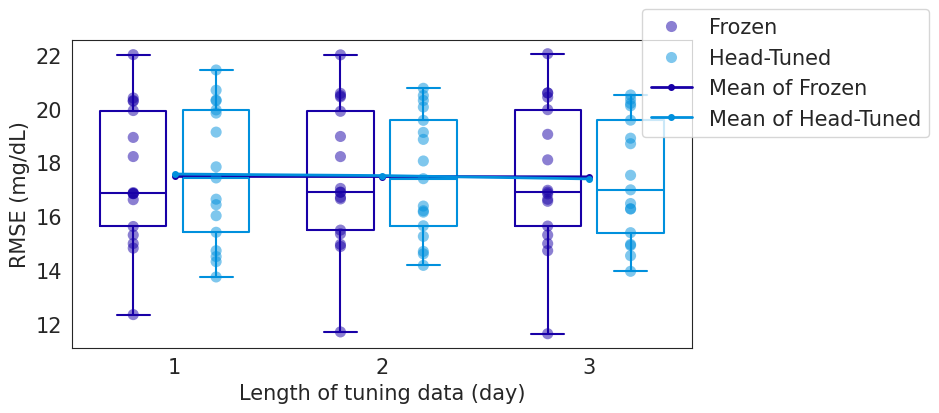

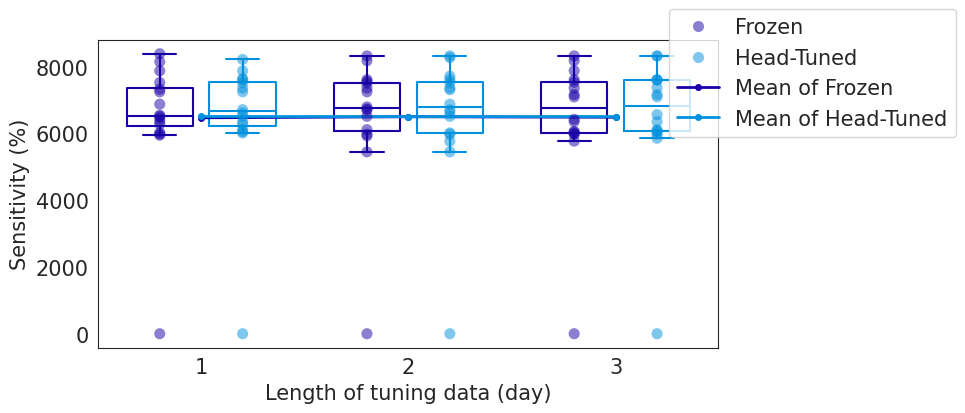

In [6]:
unique_ft_types= ['Frozen', 'Head-Tuned']
unique_cl_types= ['EWC21']

fig_data = all_results_reg[all_results_reg.FT_Type.isin(unique_ft_types) & all_results_reg.CL_Type.isin(unique_cl_types)]
fig_nohypo_data = all_results_clf[all_results_clf.FT_Type.isin(unique_ft_types) & all_results_clf.CL_Type.isin(unique_cl_types)]


plt.rc('font', size=15)

sns.set_style('white')
pal = sns.color_palette('nipy_spectral')
dark_pal = [darken_color(color) for color in pal]

'''
RMSE
'''
plt.figure(figsize = (8, 4))
sns.stripplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, legend=False)
grouped = fig_data.groupby(['Tune_length', 'FT_Type']).agg({'RMSE': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['RMSE']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)

plt.xlabel('Length of tuning data (day)')
plt.ylabel('RMSE (mg/dL)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))
plt.show()

'''
Sensitivity
'''
plt.figure(figsize = (8, 4))
sns.stripplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, showfliers=False, legend=False)

grouped = fig_nohypo_data.groupby(['Tune_length', 'FT_Type']).agg({'Sensitivity': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['Sensitivity']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)
plt.xlabel('Length of tuning data (day)')
plt.ylabel('Sensitivity (%)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))
plt.show()           

### Sim2ShanghaiT1DM

In [7]:
dataset_name = 'ShanghaiT1DM'

ph = [30]
tuning_dur = [1,2,3]

all_results = pd.DataFrame(columns=['PH', 'CL_Type', 'FT_Type', 'Tune_length', 'SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
for _ph in ph:
    for dur in tuning_dur:
        # Get Interpolation information
        if dataset_name == 'OhioT1DM':
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_interpolate_index.pkl')
        else:
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_FT{dur}DAY_interpolate_index.pkl')
        interp_info_list = pd.concat(interp_info_list, ignore_index=True)

        # Get result data
        dir_fp =  f'Results/Sim2Real/{dataset_name}/PH{_ph}/FT_{dur}DAY/'
        for file in os.listdir(dir_fp):
            if file.endswith('.csv')==False:
                continue
            cl_type = file.split('_')[2].split('.')[0]
            results = pd.read_csv(dir_fp+file)
            sid_list = results.SID.unique()

            # -- Frozen
            frozen_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            frozen_results = results[results.FT_Type == 'Frozen']
            for s_i, sid in enumerate(sid_list):
                result = frozen_results[frozen_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                frozen_perf_df = pd.concat([frozen_perf_df, perf])

            # -- Head-Tuned
            ht_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ht_results = results[results.FT_Type == 'Head-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ht_results[ht_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ht_perf_df = pd.concat([ht_perf_df, perf])

            # -- Fully-Tuned
            ft_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ft_results = results[results.FT_Type == 'Fully-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ft_results[ft_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ft_perf_df = pd.concat([ft_perf_df, perf])

            frozen_perf_df['FT_Type'], ht_perf_df['FT_Type'], ft_perf_df['FT_Type'] = 'Frozen', 'Head-Tuned', 'Fully-Tuned'
            tmp_results = pd.concat([frozen_perf_df, ht_perf_df, ft_perf_df])
            tmp_results['PH'], tmp_results['Tune_length'], tmp_results['CL_Type'] = _ph, dur, cl_type
            all_results = pd.concat([all_results, tmp_results])

all_results.to_csv(f'Results/Performance_sub/Table_{dataset_name}_PH30.csv')
all_results_reg = all_results.copy()
all_results_clf = all_results[all_results.N_hypo!=0]

r1 = all_results_reg.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['RMSE', 'MARD', 'MAE', 'Time Gain']]
r2 = all_results_clf.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['Sensitivity', 'Specificity']]

res = pd.concat([combine_mean_std(r1), combine_mean_std(r2)], axis=1).loc[:, ['RMSE', 'MAE', 'MARD', 'Sensitivity', 'Specificity', 'Time Gain']]
res.to_csv(f'Results/Performance/Table_{dataset_name}_PH30.csv')
res

RMSE          MAE         MARD  \
PH CL_Type FT_Type     Tune_length                                           
30 EWC12   Frozen      1            11.32 (1.90)  8.73 (1.60)  6.41 (1.87)   
                       2            11.13 (2.38)  8.58 (1.78)  6.06 (1.65)   
                       3            10.43 (2.63)  8.16 (2.10)  5.79 (1.84)   
           Fully-Tuned 1            11.16 (1.45)  8.31 (1.06)  5.74 (1.38)   
                       2             9.97 (2.59)  7.51 (1.95)  4.94 (1.60)   
                       3             8.33 (1.98)  6.24 (1.34)  4.19 (0.90)   
           Head-Tuned  1            11.29 (1.61)  8.43 (1.20)  6.08 (1.61)   
                       2            10.45 (2.05)  7.80 (1.32)  5.31 (1.19)   
                       3             9.28 (2.68)  7.00 (2.12)  4.78 (1.45)   
   EWC21   Frozen      1            11.09 (1.65)  8.27 (1.19)  5.59 (1.05)   
                       2            10.92 (2.02)  8.10 (1.35)  5.37 (0.99)   
                       3            10.43 (2.41)  7.82 (1.75)  5.31 (1.13)   
           Fully-Tuned 1            10.97 (1.47)  8.00 (0.83)  5.42 (1.11)   
                       2            10.15 (1.68)  7.56 (1.08)  5.02 (1.03)   
                       3             9.32 (2.45)  6.82 (1.63)  4.67 (1.13)   
           Head-Tuned  1            10.94 (1.60)  7.90 (1.02)  5.38 (1.04)   
                       2            10.82 (1.67)  7.89 (0.80)  5.19 (0.99)   
                       3             9.89 (2.14)  7.13 (1.60)  4.90 (1.11)   
   NAIVE12 Frozen      1            11.22 (1.72)  8.44 (1.39)  6.13 (1.78)   
                       2            11.01 (2.16)  8.33 (1.58)  5.84 (1.54)   
                       3            10.41 (2.49)  7.95 (2.03)  5.61 (1.73)   
           Fully-Tuned 1            11.52 (1.73)  8.60 (1.41)  5.92 (1.58)   
                       2            10.30 (2.69)  7.77 (2.02)  5.12 (1.63)   
                       3             8.39 (1.89)  6.32 (1.33)  4.28 (0.97)   
           Head-Tuned  1            11.38 (1.66)  8.48 (1.29)  6.09 (1.64)   
                       2            10.77 (1.93)  7.99 (1.20)  5.39 (1.13)   
                       3             9.49 (2.54)  7.14 (1.99)  4.87 (1.32)   
   NAIVE21 Frozen      1            11.50 (1.85)  8.64 (1.40)  5.81 (1.11)   
                       2            11.34 (2.19)  8.49 (1.54)  5.57 (1.03)   
                       3            10.83 (2.55)  8.12 (1.87)  5.47 (1.13)   
           Fully-Tuned 1            11.26 (1.72)  8.09 (1.08)  5.47 (0.97)   
                       2            10.26 (1.87)  7.54 (0.97)  4.99 (0.86)   
                       3             9.70 (2.31)  7.09 (1.50)  4.83 (1.02)   
           Head-Tuned  1            11.44 (1.79)  8.22 (1.15)  5.54 (1.02)   
                       2            11.08 (1.88)  7.97 (0.89)  5.22 (0.91)   
                       3            10.03 (2.19)  7.11 (1.54)  4.86 (0.97)   

                                          Sensitivity       Specificity  \
PH CL_Type FT_Type     Tune_length                                        
30 EWC12   Frozen      1            5589.44 (3572.14)  9767.66 (266.33)   
                       2            4816.99 (3065.86)  9777.20 (199.82)   
                       3            5833.33 (4194.35)  9726.90 (270.02)   
           Fully-Tuned 1            6818.20 (3866.02)  9725.22 (308.46)   
                       2            6885.62 (3932.30)  9727.98 (274.93)   
                       3            7500.00 (5000.00)  9675.36 (298.93)   
           Head-Tuned  1            5785.52 (3590.84)  9762.88 (275.67)   
                       2            5316.99 (3298.22)  9772.60 (231.08)   
                       3            5833.33 (4194.35)  9736.30 (253.17)   
   EWC21   Frozen      1            7061.40 (4314.55)  9689.47 (247.60)   
                       2            6666.67 (4124.79)  9687.02 (219.30)   
                       3            6666.67 (4714.05)  9615.40 (179.41)   
           Fully-Tuned 1     

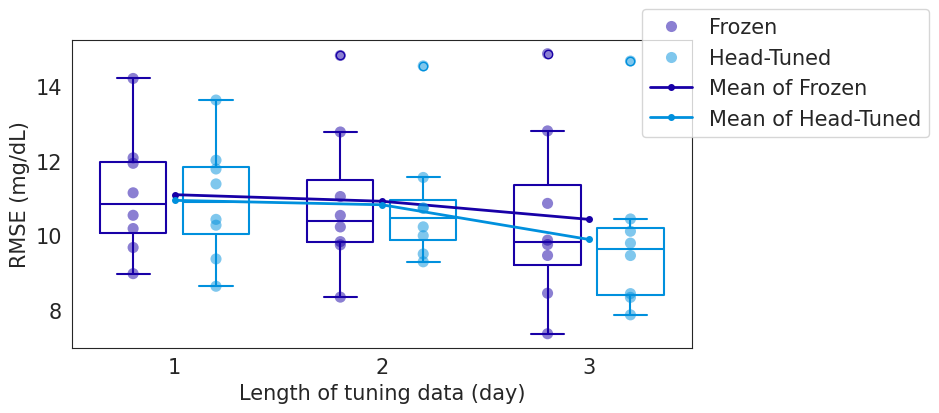

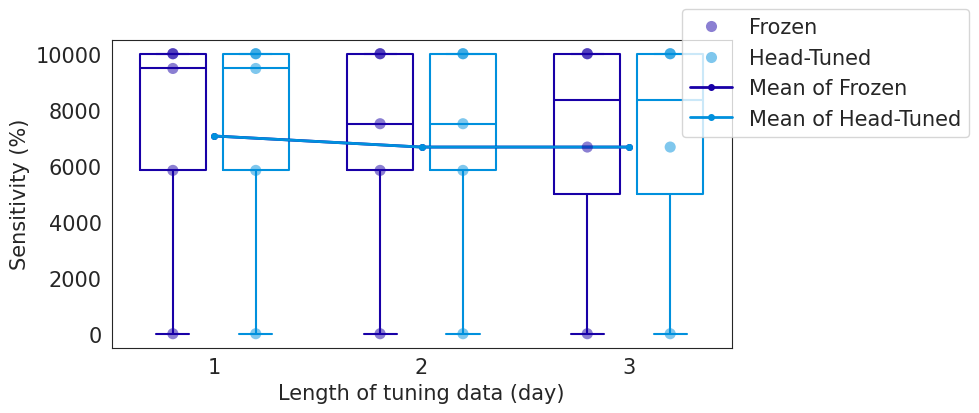

In [8]:
unique_ft_types= ['Frozen', 'Head-Tuned']
unique_cl_types= ['EWC21']

fig_data = all_results_reg[all_results_reg.FT_Type.isin(unique_ft_types) & all_results_reg.CL_Type.isin(unique_cl_types)]
fig_nohypo_data = all_results_clf[all_results_clf.FT_Type.isin(unique_ft_types) & all_results_clf.CL_Type.isin(unique_cl_types)]


plt.rc('font', size=15)

sns.set_style('white')
pal = sns.color_palette('nipy_spectral')
dark_pal = [darken_color(color) for color in pal]

'''
RMSE
'''
plt.figure(figsize = (8, 4))
sns.stripplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, legend=False)
grouped = fig_data.groupby(['Tune_length', 'FT_Type']).agg({'RMSE': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['RMSE']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)

# plt.title(f"Comparison of RMSE with increasing tuning data length")
plt.xlabel('Length of tuning data (day)')
plt.ylabel('RMSE (mg/dL)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))
plt.show()

'''
Sensitivity
'''
plt.figure(figsize = (8, 4))
sns.stripplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, showfliers=False, legend=False)

grouped = fig_nohypo_data.groupby(['Tune_length', 'FT_Type']).agg({'Sensitivity': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['Sensitivity']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)
plt.xlabel('Length of tuning data (day)')
plt.ylabel('Sensitivity (%)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))
plt.show()           

### Sim2OhioT1DM

In [9]:
dataset_name = 'OhioT1DM'

ph = [30]
tuning_dur = np.arange(15)+1

all_results = pd.DataFrame(columns=['PH', 'CL_Type', 'FT_Type', 'Tune_length', 'SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
for _ph in ph:
    for dur in tuning_dur:
        # Get Interpolation information
        if dataset_name == 'OhioT1DM':
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_interpolate_index.pkl')
        else:
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_FT{dur}DAY_interpolate_index.pkl')
        interp_info_list = pd.concat(interp_info_list, ignore_index=True)

        # Get result data
        dir_fp =  f'Results/Sim2Real/{dataset_name}/PH{_ph}/FT_{dur}DAY/'
        for file in os.listdir(dir_fp):
            if file.endswith('.csv')==False:
                continue
            cl_type = file.split('_')[2].split('.')[0]
            results = pd.read_csv(dir_fp+file)
            sid_list = results.SID.unique()

            # -- Frozen
            frozen_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            frozen_results = results[results.FT_Type == 'Frozen']
            for s_i, sid in enumerate(sid_list):
                result = frozen_results[frozen_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                frozen_perf_df = pd.concat([frozen_perf_df, perf])

            # -- Head-Tuned
            ht_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ht_results = results[results.FT_Type == 'Head-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ht_results[ht_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ht_perf_df = pd.concat([ht_perf_df, perf])

            # -- Fully-Tuned
            ft_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ft_results = results[results.FT_Type == 'Fully-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ft_results[ft_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ft_perf_df = pd.concat([ft_perf_df, perf])

            frozen_perf_df['FT_Type'], ht_perf_df['FT_Type'], ft_perf_df['FT_Type'] = 'Frozen', 'Head-Tuned', 'Fully-Tuned'
            tmp_results = pd.concat([frozen_perf_df, ht_perf_df, ft_perf_df])
            tmp_results['PH'], tmp_results['Tune_length'], tmp_results['CL_Type'] = _ph, dur, cl_type
            all_results = pd.concat([all_results, tmp_results])

all_results.to_csv(f'Results/Performance_sub/Table_{dataset_name}_PH30.csv')
all_results_reg = all_results.copy()
all_results_clf = all_results[all_results.N_hypo!=0]

r1 = all_results_reg.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['RMSE', 'MARD', 'MAE', 'Time Gain']]
r2 = all_results_clf.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['Sensitivity', 'Specificity']]

res = pd.concat([combine_mean_std(r1), combine_mean_std(r2)], axis=1).loc[:, ['RMSE', 'MAE', 'MARD', 'Sensitivity', 'Specificity', 'Time Gain']]
res.to_csv(f'Results/Performance/Table_{dataset_name}_PH30.csv')
res

RMSE           MAE         MARD  \
PH CL_Type FT_Type     Tune_length                                            
30 EWC12   Frozen      1            15.11 (2.77)  10.72 (1.80)  7.82 (1.95)   
                       2            15.12 (2.77)  10.72 (1.81)  7.83 (1.96)   
                       3            15.14 (2.76)  10.74 (1.82)  7.84 (1.96)   
                       4            15.09 (2.77)  10.71 (1.80)  7.81 (1.93)   
                       5            15.09 (2.74)  10.72 (1.81)  7.82 (1.95)   
                       6            15.12 (2.76)  10.75 (1.80)  7.83 (1.94)   
                       7            15.15 (2.77)  10.73 (1.80)  7.83 (1.94)   
                       8            15.09 (2.78)  10.72 (1.81)  7.83 (1.96)   
                       9            15.11 (2.81)  10.72 (1.82)  7.83 (1.96)   
                       10           15.12 (2.76)  10.73 (1.78)  7.83 (1.95)   
                       11           15.13 (2.75)  10.75 (1.81)  7.84 (1.95)   
                       12           15.12 (2.72)  10.72 (1.79)  7.82 (1.94)   
                       13           15.10 (2.78)  10.74 (1.80)  7.83 (1.94)   
                       14           15.09 (2.78)  10.71 (1.80)  7.82 (1.95)   
                       15           15.10 (2.76)  10.72 (1.81)  7.82 (1.95)   
           Fully-Tuned 1            15.28 (2.80)  11.06 (2.21)  8.08 (2.29)   
                       2            15.28 (2.55)  11.11 (1.88)  8.12 (2.18)   
                       3            15.53 (2.93)  11.39 (2.42)  8.29 (2.35)   
                       4            15.38 (3.62)  11.27 (2.90)  8.19 (2.40)   
                       5            15.39 (3.98)  11.23 (3.25)  8.15 (2.85)   
                       6            14.96 (3.51)  11.00 (2.77)  8.06 (2.57)   
                       7            14.76 (3.27)  10.76 (2.51)  7.85 (2.38)   
                       8            14.61 (3.00)  10.69 (2.16)  7.82 (2.17)   
                       9            14.60 (2.91)  10.65 (2.07)  7.84 (2.16)   
                       10           14.56 (2.88)  10.53 (2.00)  7.66 (2.01)   
                       11           14.48 (2.86)  10.43 (1.98)  7.55 (1.96)   
                       12           14.48 (2.85)  10.44 (1.99)  7.59 (1.98)   
                       13           14.65 (2.81)  10.56 (1.98)  7.64 (1.95)   
                       14           14.61 (2.79)  10.50 (1.94)  7.56 (1.90)   
                       15           14.68 (2.82)  10.56 (1.91)  7.62 (1.98)   
           Head-Tuned  1            15.24 (2.74)  10.86 (1.89)  7.78 (1.93)   
                       2            15.35 (2.56)  11.05 (1.82)  8.01 (1.91)   
                       3            15.48 (2.90)  11.18 (2.17)  8.02 (2.04)   
                       4            15.47 (3.23)  11.19 (2.49)  8.02 (2.11)   
                       5            15.38 (3.33)  11.15 (2.66)  8.05 (2.32)   
                       6            15.02 (2.99)  10.91 (2.28)  7.98 (2.13)   
                       7            15.15 (3.14)  11.04 (2.52)  8.11 (2.46)   
                       8            15.08 (2.68)  11.02 (2.01)  8.12 (2.17)   
                       9            15.08 (2.62)  10.98 (1.98)  8.12 (2.14)   
                       10           14.92 (2.66)  10.83 (1.99)  7.97 (2.12)   
                       11           15.00 (2.59)  10.81 (1.90)  7.87 (2.01)   
                       12           15.01 (2.60)  10.84 (1.96)  7.93 (2.06)   
                       13           15.08 (2.65)  10.90 (1.95)  7.96 (2.06)   
                       14           14.98 (2.70)  10.77 (1.96)  7.82 (2.01)   
                       15           15.13 (2.58)  10.92 (1.85)  7.93 (2.00)   
   EWC21   Frozen      1            14.67 (2.91)  10.15 (1.81)  7.02 (1.59)   
                       2            14.69 (2.92)  10.15 (1.82)  7.02 (1.61)   
                       3            14.67 (2.94)  10.13 (1.81)  7.02 (1.61)   
                       4            14.66 (2.93)  10.13 (1.83)  7.01 (1.61)   
               

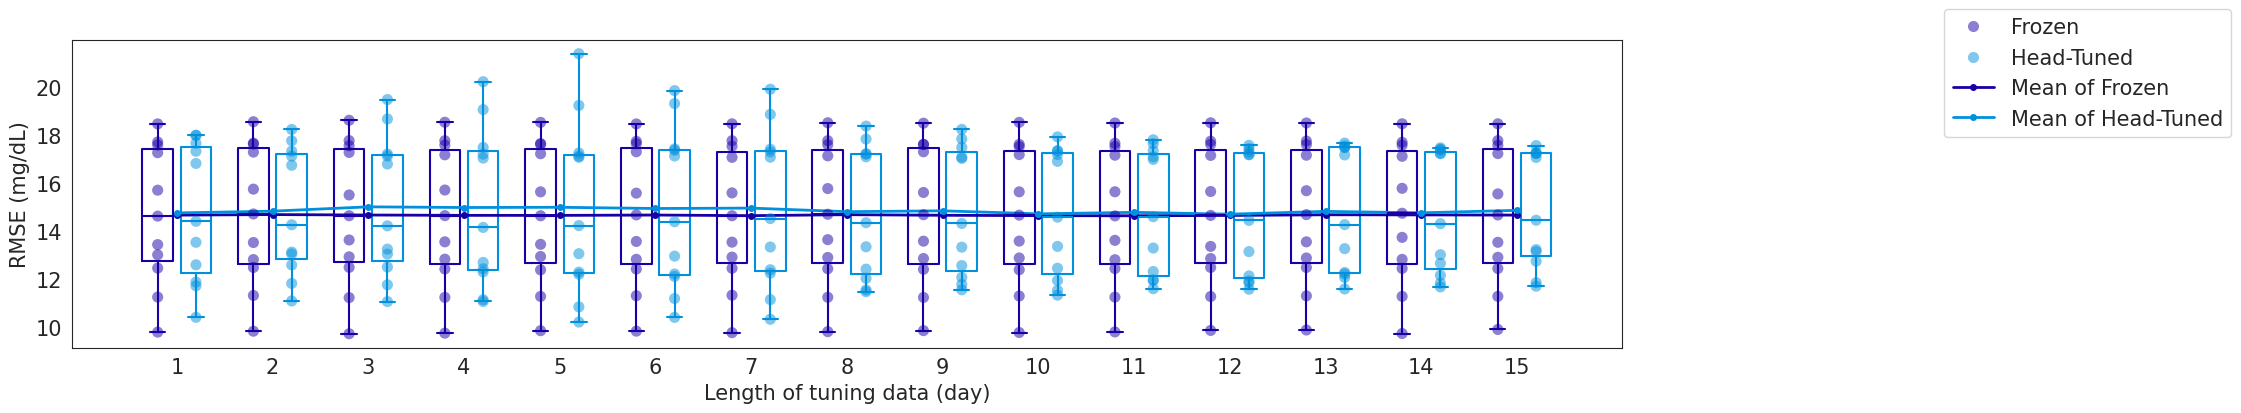

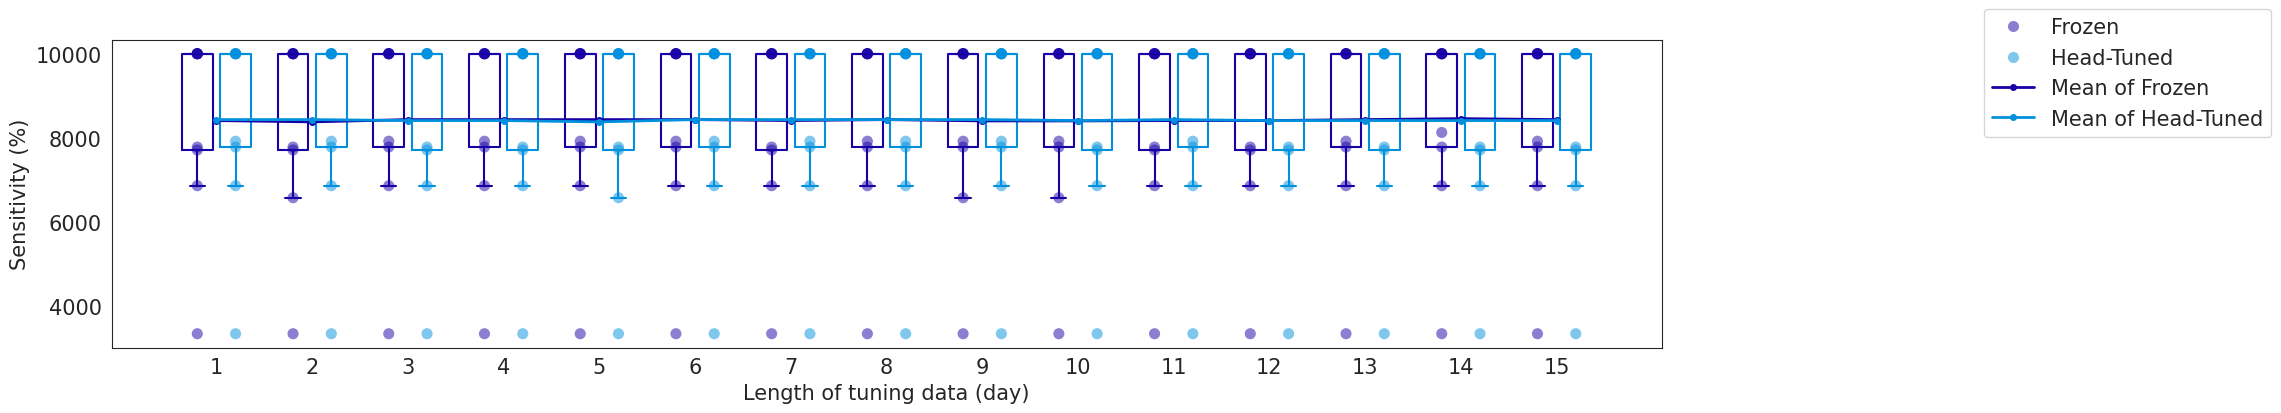

In [10]:
unique_ft_types= ['Frozen', 'Head-Tuned']
unique_cl_types= ['EWC21']

fig_data = all_results_reg[all_results_reg.FT_Type.isin(unique_ft_types) & all_results_reg.CL_Type.isin(unique_cl_types)]
fig_nohypo_data = all_results_clf[all_results_clf.FT_Type.isin(unique_ft_types) & all_results_clf.CL_Type.isin(unique_cl_types)]


plt.rc('font', size=15)

sns.set_style('white')
pal = sns.color_palette('nipy_spectral')
dark_pal = [darken_color(color) for color in pal]

'''
RMSE
'''
plt.figure(figsize = (20, 4))
sns.stripplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, legend=False)
grouped = fig_data.groupby(['Tune_length', 'FT_Type']).agg({'RMSE': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['RMSE']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)

# plt.title(f"Comparison of RMSE with increasing tuning data length")
plt.xlabel('Length of tuning data (day)')
plt.ylabel('RMSE (mg/dL)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))
plt.show()

'''
Sensitivity
'''
plt.figure(figsize = (20, 4))
sns.stripplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, showfliers=False, legend=False)

grouped = fig_nohypo_data.groupby(['Tune_length', 'FT_Type']).agg({'Sensitivity': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['Sensitivity']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)
plt.xlabel('Length of tuning data (day)')
plt.ylabel('Sensitivity (%)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))

plt.show()           

## PH60

### Sim2Diatrend

In [11]:
dataset_name = 'DiaTrend'

ph = [60]
tuning_dur = [1,2,3]

all_results = pd.DataFrame(columns=['PH', 'CL_Type', 'FT_Type', 'Tune_length', 'SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
for _ph in ph:
    for dur in tuning_dur:
        # Get Interpolation information
        if dataset_name == 'OhioT1DM':
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_interpolate_index.pkl')
        else:
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_FT{dur}DAY_interpolate_index.pkl')
        interp_info_list = pd.concat(interp_info_list, ignore_index=True)

        # Get result data
        dir_fp =  f'Results/Sim2Real/{dataset_name}/PH{_ph}/FT_{dur}DAY/'
        for file in os.listdir(dir_fp):
            if file.endswith('.csv')==False:
                continue
            cl_type = file.split('_')[2].split('.')[0]
            results = pd.read_csv(dir_fp+file)
            sid_list = results.SID.unique()

            # -- Frozen
            frozen_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            frozen_results = results[results.FT_Type == 'Frozen']
            for s_i, sid in enumerate(sid_list):
                result = frozen_results[frozen_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == str(sid)][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                frozen_perf_df = pd.concat([frozen_perf_df, perf])

            # -- Head-Tuned
            ht_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ht_results = results[results.FT_Type == 'Head-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ht_results[ht_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == str(sid)][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ht_perf_df = pd.concat([ht_perf_df, perf])

            # -- Fully-Tuned
            ft_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ft_results = results[results.FT_Type == 'Fully-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ft_results[ft_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == str(sid)][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ft_perf_df = pd.concat([ft_perf_df, perf])

            frozen_perf_df['FT_Type'], ht_perf_df['FT_Type'], ft_perf_df['FT_Type'] = 'Frozen', 'Head-Tuned', 'Fully-Tuned'
            tmp_results = pd.concat([frozen_perf_df, ht_perf_df, ft_perf_df])
            tmp_results['PH'], tmp_results['Tune_length'], tmp_results['CL_Type'] = _ph, dur, cl_type
            all_results = pd.concat([all_results, tmp_results])

all_results.to_csv(f'Results/Performance_sub/Table_{dataset_name}_PH60.csv')
all_results_reg = all_results.copy()
all_results_clf = all_results[all_results.N_hypo!=0]

r1 = all_results_reg.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['RMSE', 'MARD', 'MAE', 'Time Gain']]
r2 = all_results_clf.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['Sensitivity', 'Specificity']]

res = pd.concat([combine_mean_std(r1), combine_mean_std(r2)], axis=1).loc[:, ['RMSE', 'MAE', 'MARD', 'Sensitivity', 'Specificity', 'Time Gain']]
res.to_csv(f'Results/Performance/Table_{dataset_name}_PH60.csv')
res

RMSE           MAE          MARD  \
PH CL_Type FT_Type     Tune_length                                             
60 EWC12   Frozen      1            34.80 (4.61)  25.84 (3.32)  16.94 (2.55)   
                       2            34.83 (4.78)  25.86 (3.38)  16.98 (2.63)   
                       3            34.69 (4.83)  25.77 (3.44)  16.96 (2.65)   
           Fully-Tuned 1            33.81 (4.97)  25.08 (3.66)  16.18 (2.12)   
                       2            33.53 (4.89)  25.08 (3.37)  16.36 (2.06)   
                       3            33.28 (4.83)  24.84 (3.44)  16.23 (2.21)   
           Head-Tuned  1            34.06 (4.73)  25.12 (3.47)  16.18 (2.24)   
                       2            33.86 (4.55)  25.12 (3.22)  16.19 (2.15)   
                       3            33.24 (4.88)  24.67 (3.49)  15.99 (2.20)   
   EWC21   Frozen      1            38.00 (5.24)  28.68 (4.75)  18.22 (3.18)   
                       2            38.03 (5.35)  28.72 (4.77)  18.27 (3.22)   
                       3            37.94 (5.41)  28.65 (4.83)  18.27 (3.23)   
           Fully-Tuned 1            35.01 (5.29)  25.80 (3.96)  16.07 (2.15)   
                       2            34.04 (5.23)  25.42 (3.86)  16.33 (2.35)   
                       3            33.70 (4.93)  25.15 (3.59)  16.25 (2.23)   
           Head-Tuned  1            36.14 (4.71)  26.75 (3.42)  16.74 (1.97)   
                       2            34.92 (5.57)  25.84 (4.07)  16.21 (2.25)   
                       3            34.64 (5.37)  25.54 (3.82)  16.10 (2.15)   
   NAIVE12 Frozen      1            34.92 (4.88)  25.96 (3.51)  17.29 (2.91)   
                       2            34.92 (5.05)  25.98 (3.57)  17.32 (3.00)   
                       3            34.79 (5.11)  25.90 (3.63)  17.30 (3.01)   
           Fully-Tuned 1            33.81 (4.92)  25.19 (3.57)  16.49 (2.27)   
                       2            33.64 (4.75)  25.29 (3.23)  16.73 (2.17)   
                       3            33.44 (5.17)  25.14 (3.72)  16.66 (2.45)   
           Head-Tuned  1            33.94 (4.86)  25.17 (3.52)  16.50 (2.48)   
                       2            33.79 (4.77)  25.24 (3.31)  16.54 (2.23)   
                       3            33.42 (4.93)  25.06 (3.47)  16.49 (2.20)   
   NAIVE21 Frozen      1            38.01 (5.27)  28.77 (4.82)  18.32 (3.35)   
                       2            38.02 (5.36)  28.80 (4.83)  18.36 (3.39)   
                       3            37.93 (5.41)  28.73 (4.88)  18.36 (3.39)   
           Fully-Tuned 1            35.26 (5.08)  26.05 (3.73)  16.23 (2.17)   
                       2            34.08 (5.30)  25.50 (3.85)  16.33 (2.31)   
                       3            33.88 (4.96)  25.34 (3.56)  16.39 (2.24)   
           Head-Tuned  1            36.87 (4.70)  27.50 (3.64)  17.08 (2.34)   
                       2            35.62 (5.50)  26.38 (3.99)  16.46 (2.25)   
                       3            34.69 (5.38)  25.72 (3.81)  16.27 (2.20)   

                                          Sensitivity       Specificity  \
PH CL_Type FT_Type     Tune_length                                        
60 EWC12   Frozen      1            2119.36 (1576.56)  9707.78 (327.39)   
                       2            2106.85 (1573.93)  9705.26 (329.02)   
                       3            2468.19 (2536.50)  9708.54 (329.01)   
           Fully-Tuned 1            1971.15 (1515.89)  9781.81 (202.46)   
                       2            1957.96 (1523.23)  9821.02 (143.99)   
                       3            1699.86 (1083.10)  9831.51 (125.03)   
           Head-Tuned  1            2075.88 (1577.47)  9711.60 (325.37)   
                       2            2091.98 (1533.59)  9708.89 (324.69)   
                       3            2053.27 (1591.58)  9716.02 (309.79)   
   EWC21   Frozen      1            4829.08 (2167.91)  9218.47 (624.48)   
                       2            4913.45 (2112.27)  9219.52 (621.75)   
                       3    

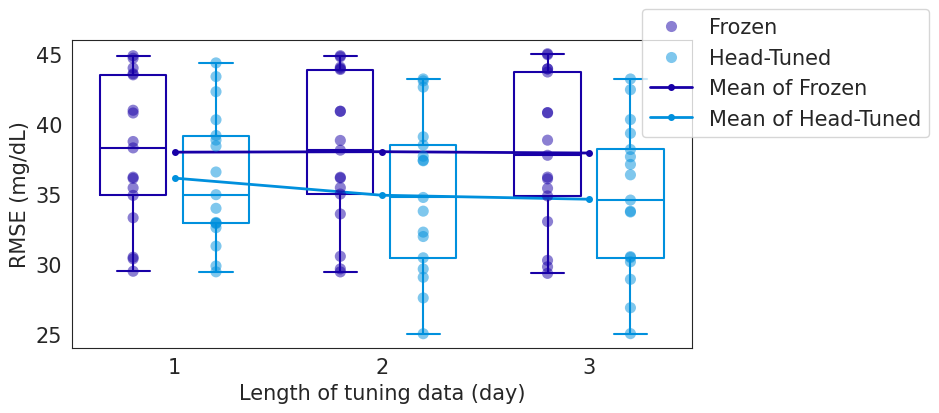

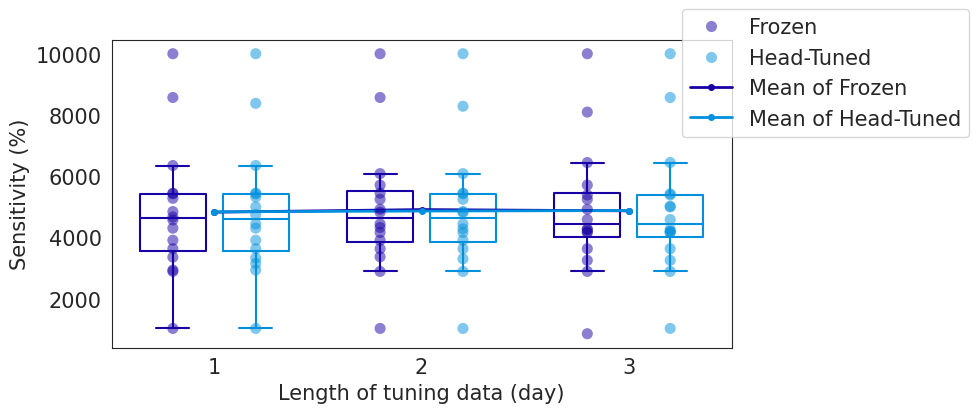

In [12]:
unique_ft_types= ['Frozen', 'Head-Tuned']
unique_cl_types= ['EWC21']

fig_data = all_results_reg[all_results_reg.FT_Type.isin(unique_ft_types) & all_results_reg.CL_Type.isin(unique_cl_types)]
fig_nohypo_data = all_results_clf[all_results_clf.FT_Type.isin(unique_ft_types) & all_results_clf.CL_Type.isin(unique_cl_types)]


plt.rc('font', size=15)

sns.set_style('white')
pal = sns.color_palette('nipy_spectral')
dark_pal = [darken_color(color) for color in pal]

'''
RMSE
'''
plt.figure(figsize = (8, 4))
sns.stripplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, legend=False)
grouped = fig_data.groupby(['Tune_length', 'FT_Type']).agg({'RMSE': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['RMSE']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)

# plt.title(f"Comparison of RMSE with increasing tuning data length")
plt.xlabel('Length of tuning data (day)')
plt.ylabel('RMSE (mg/dL)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))
plt.show()

'''
Sensitivity
'''
plt.figure(figsize = (8, 4))
sns.stripplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, showfliers=False, legend=False)

grouped = fig_nohypo_data.groupby(['Tune_length', 'FT_Type']).agg({'Sensitivity': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['Sensitivity']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)
plt.xlabel('Length of tuning data (day)')
plt.ylabel('Sensitivity (%)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))

# plt.title(f"Comparison of Sensitivity with increasing tuning data length")
plt.show()           

### Sim2ShanghaiT1DM

In [13]:
dataset_name = 'ShanghaiT1DM'

ph = [60]
tuning_dur = [1,2,3]

all_results = pd.DataFrame(columns=['PH', 'CL_Type', 'FT_Type', 'Tune_length', 'SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
for _ph in ph:
    for dur in tuning_dur:
        # Get Interpolation information
        if dataset_name == 'OhioT1DM':
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_interpolate_index.pkl')
        else:
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_FT{dur}DAY_interpolate_index.pkl')
        interp_info_list = pd.concat(interp_info_list, ignore_index=True)

        # Get result data
        dir_fp =  f'Results/Sim2Real/{dataset_name}/PH{_ph}/FT_{dur}DAY/'
        for file in os.listdir(dir_fp):
            if file.endswith('.csv')==False:
                continue
            cl_type = file.split('_')[2].split('.')[0]
            results = pd.read_csv(dir_fp+file)
            sid_list = results.SID.unique()

            # -- Frozen
            frozen_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            frozen_results = results[results.FT_Type == 'Frozen']
            for s_i, sid in enumerate(sid_list):
                result = frozen_results[frozen_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                frozen_perf_df = pd.concat([frozen_perf_df, perf])

            # -- Head-Tuned
            ht_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ht_results = results[results.FT_Type == 'Head-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ht_results[ht_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ht_perf_df = pd.concat([ht_perf_df, perf])

            # -- Fully-Tuned
            ft_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ft_results = results[results.FT_Type == 'Fully-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ft_results[ft_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ft_perf_df = pd.concat([ft_perf_df, perf])

            frozen_perf_df['FT_Type'], ht_perf_df['FT_Type'], ft_perf_df['FT_Type'] = 'Frozen', 'Head-Tuned', 'Fully-Tuned'
            tmp_results = pd.concat([frozen_perf_df, ht_perf_df, ft_perf_df])
            tmp_results['PH'], tmp_results['Tune_length'], tmp_results['CL_Type'] = _ph, dur, cl_type
            all_results = pd.concat([all_results, tmp_results])

all_results.to_csv(f'Results/Performance_sub/Table_{dataset_name}_PH60.csv')
all_results_reg = all_results.copy()
all_results_clf = all_results[all_results.N_hypo!=0]

r1 = all_results_reg.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['RMSE', 'MARD', 'MAE', 'Time Gain']]
r2 = all_results_clf.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['Sensitivity', 'Specificity']]

res = pd.concat([combine_mean_std(r1), combine_mean_std(r2)], axis=1).loc[:, ['RMSE', 'MAE', 'MARD', 'Sensitivity', 'Specificity', 'Time Gain']]
res.to_csv(f'Results/Performance/Table_{dataset_name}_PH60.csv')
res

RMSE           MAE          MARD  \
PH CL_Type FT_Type     Tune_length                                             
60 EWC12   Frozen      1            25.74 (4.46)  19.28 (3.80)  14.41 (5.10)   
                       2            24.77 (5.36)  18.65 (4.32)  13.56 (4.38)   
                       3            22.81 (7.97)  17.60 (6.40)  13.01 (6.18)   
           Fully-Tuned 1            24.24 (3.91)  18.11 (3.03)  12.80 (3.89)   
                       2            22.28 (4.83)  17.24 (3.35)  11.52 (2.89)   
                       3            21.00 (6.11)  16.43 (4.63)  11.14 (3.90)   
           Head-Tuned  1            24.71 (4.21)  18.31 (3.17)  13.52 (4.54)   
                       2            23.11 (5.21)  17.41 (3.64)  12.11 (3.40)   
                       3            20.63 (7.12)  15.74 (5.41)  11.20 (4.72)   
   EWC21   Frozen      1            27.92 (5.18)  22.16 (4.42)  15.28 (3.37)   
                       2            27.14 (5.68)  21.65 (4.66)  14.52 (2.94)   
                       3            26.34 (6.66)  21.11 (5.27)  14.33 (4.13)   
           Fully-Tuned 1            24.18 (4.14)  17.95 (2.68)  12.11 (2.51)   
                       2            22.21 (3.58)  16.61 (2.44)  10.92 (1.92)   
                       3            21.09 (6.22)  15.90 (4.60)  10.62 (3.51)   
           Head-Tuned  1            25.87 (4.40)  19.11 (2.90)  13.23 (3.18)   
                       2            23.47 (4.90)  17.01 (3.09)  11.28 (2.26)   
                       3            21.49 (7.27)  15.53 (4.95)  10.64 (3.67)   
   NAIVE12 Frozen      1            26.80 (4.93)  20.34 (4.20)  15.35 (5.44)   
                       2            25.62 (5.90)  19.44 (4.85)  14.27 (4.72)   
                       3            23.57 (8.45)  18.36 (6.81)  13.72 (6.63)   
           Fully-Tuned 1            24.90 (4.49)  18.72 (3.13)  13.13 (3.66)   
                       2            23.17 (4.98)  17.91 (3.39)  11.89 (2.78)   
                       3            21.21 (6.22)  16.53 (4.76)  11.09 (3.67)   
           Head-Tuned  1            25.59 (4.39)  19.02 (3.46)  14.14 (4.73)   
                       2            23.15 (5.46)  17.41 (3.72)  12.12 (3.40)   
                       3            20.89 (7.11)  16.06 (5.31)  11.28 (4.45)   
   NAIVE21 Frozen      1            27.31 (5.05)  21.44 (4.27)  14.73 (3.27)   
                       2            26.63 (5.53)  20.98 (4.43)  14.06 (2.92)   
                       3            25.79 (6.60)  20.34 (4.98)  13.79 (4.03)   
           Fully-Tuned 1            24.46 (4.10)  18.00 (2.68)  12.14 (2.61)   
                       2            22.50 (3.79)  16.85 (2.67)  11.13 (2.42)   
                       3            21.03 (5.83)  15.83 (4.00)  10.47 (3.00)   
           Head-Tuned  1            25.79 (4.57)  18.83 (3.27)  13.00 (3.26)   
                       2            23.55 (5.01)  16.89 (2.99)  11.19 (2.29)   
                       3            21.87 (7.38)  15.66 (4.71)  10.65 (3.59)   

                                          Sensitivity       Specificity  \
PH CL_Type FT_Type     Tune_length                                        
60 EWC12   Frozen      1            2306.07 (3483.74)  9782.01 (251.07)   
                       2            1470.59 (3288.34)  9827.84 (174.25)   
                       3            2976.19 (5154.91)  9614.79 (152.95)   
           Fully-Tuned 1            2954.07 (3544.35)  9694.72 (348.95)   
                       2            2209.15 (3820.71)  9608.95 (490.77)   
                       3            4444.44 (5091.75)  9229.58 (435.58)   
           Head-Tuned  1            2411.34 (3543.23)  9785.97 (257.53)   
                       2            1470.59 (3288.34)  9807.03 (187.96)   
                       3            2976.19 (5154.91)  9550.39 (144.67)   
   EWC21   Frozen      1            4633.83 (3028.60)  9569.32 (245.56)   
                       2            3300.65 (3166.56)  9622.89 (137.91)   
                       3    

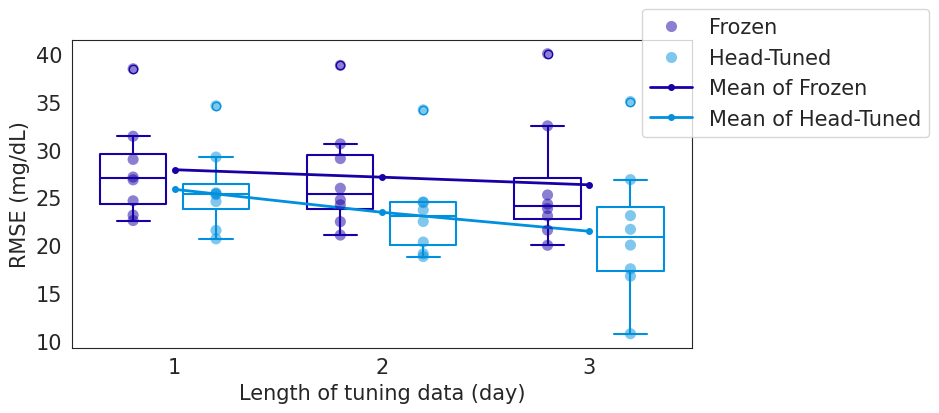

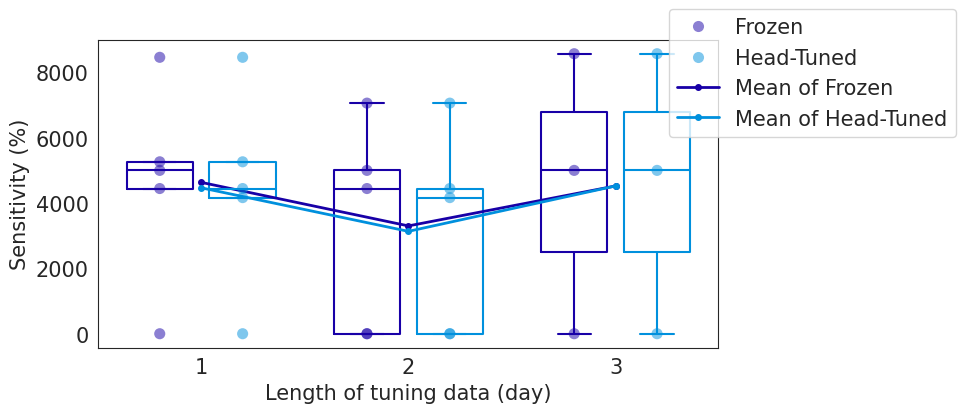

In [14]:
unique_ft_types= ['Frozen', 'Head-Tuned']
unique_cl_types= ['EWC21']

fig_data = all_results_reg[all_results_reg.FT_Type.isin(unique_ft_types) & all_results_reg.CL_Type.isin(unique_cl_types)]
fig_nohypo_data = all_results_clf[all_results_clf.FT_Type.isin(unique_ft_types) & all_results_clf.CL_Type.isin(unique_cl_types)]


plt.rc('font', size=15)

sns.set_style('white')
pal = sns.color_palette('nipy_spectral')
dark_pal = [darken_color(color) for color in pal]

'''
RMSE
'''
plt.figure(figsize = (8, 4))
sns.stripplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, legend=False)
grouped = fig_data.groupby(['Tune_length', 'FT_Type']).agg({'RMSE': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['RMSE']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)

# plt.title(f"Comparison of RMSE with increasing tuning data length")
plt.xlabel('Length of tuning data (day)')
plt.ylabel('RMSE (mg/dL)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))
plt.show()

'''
Sensitivity
'''
plt.figure(figsize = (8, 4))
sns.stripplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, showfliers=False, legend=False)

grouped = fig_nohypo_data.groupby(['Tune_length', 'FT_Type']).agg({'Sensitivity': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['Sensitivity']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)
plt.xlabel('Length of tuning data (day)')
plt.ylabel('Sensitivity (%)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))

# plt.title(f"Comparison of Sensitivity with increasing tuning data length")
plt.show()           

### Sim2OhioT1DM

In [15]:
dataset_name = 'OhioT1DM'

ph = [60]
tuning_dur = [1,2,3]

all_results = pd.DataFrame(columns=['PH', 'CL_Type', 'FT_Type', 'Tune_length', 'SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
for _ph in ph:
    for dur in tuning_dur:
        # Get Interpolation information
        if dataset_name == 'OhioT1DM':
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_interpolate_index.pkl')
        else:
            interp_info_list = pd.read_pickle(f'Datasets/interpolation_info/{dataset_name}_FT{dur}DAY_interpolate_index.pkl')
        interp_info_list = pd.concat(interp_info_list, ignore_index=True)

        # Get result data
        dir_fp =  f'Results/Sim2Real/{dataset_name}/PH{_ph}/FT_{dur}DAY/'

        for file in os.listdir(dir_fp):
            if file.endswith('.csv')==False:
                continue
            cl_type = file.split('_')[2].split('.')[0]
            results = pd.read_csv(dir_fp+file)
            sid_list = results.SID.unique()

            # -- Frozen
            frozen_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            frozen_results = results[results.FT_Type == 'Frozen']
            for s_i, sid in enumerate(sid_list):
                result = frozen_results[frozen_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                frozen_perf_df = pd.concat([frozen_perf_df, perf])

            # -- Head-Tuned
            ht_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ht_results = results[results.FT_Type == 'Head-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ht_results[ht_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ht_perf_df = pd.concat([ht_perf_df, perf])

            # -- Fully-Tuned
            ft_perf_df = pd.DataFrame(columns=['SID', 'N', 'N_hypo', 'N_hyper', 'RMSE', 'MARD', 'MAE', 'Time Gain', 'PICP', 'Sensitivity', 'Specificity'])
            ft_results = results[results.FT_Type == 'Fully-Tuned']
            for s_i, sid in enumerate(sid_list):
                result = ft_results[ft_results.SID==sid]
                
                interp_info = interp_info_list[interp_info_list.SID == sid][-len(result):].reset_index(drop=True)
                valid_idx = list(interp_info[interp_info.is_interpolated==False].index)
                
                perf = get_performance(result.true, result.pred, result.prob, result.error, _ph, valid_idx, sid, 0.5)
                ft_perf_df = pd.concat([ft_perf_df, perf])

            frozen_perf_df['FT_Type'], ht_perf_df['FT_Type'], ft_perf_df['FT_Type'] = 'Frozen', 'Head-Tuned', 'Fully-Tuned'
            tmp_results = pd.concat([frozen_perf_df, ht_perf_df, ft_perf_df])
            tmp_results['PH'], tmp_results['Tune_length'], tmp_results['CL_Type'] = _ph, dur, cl_type
            all_results = pd.concat([all_results, tmp_results])

all_results.to_csv(f'Results/Performance_sub/Table_{dataset_name}_PH60.csv')
all_results_reg = all_results.copy()
all_results_clf = all_results[all_results.N_hypo!=0]

r1 = all_results_reg.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['RMSE', 'MARD', 'MAE', 'Time Gain']]
r2 = all_results_clf.drop(columns=['N', 'N_hypo', 'N_hyper','SID']).groupby(['PH', 'CL_Type', 'FT_Type', 'Tune_length']).agg(['mean', 'std'])[['Sensitivity', 'Specificity']]

res = pd.concat([combine_mean_std(r1), combine_mean_std(r2)], axis=1).loc[:, ['RMSE', 'MAE', 'MARD', 'Sensitivity', 'Specificity', 'Time Gain']]
res.to_csv(f'Results/Performance/Table_{dataset_name}_PH60.csv')
res

RMSE           MAE          MARD  \
PH CL_Type FT_Type     Tune_length                                             
60 EWC12   Frozen      1            30.94 (5.43)  22.90 (3.90)  16.23 (3.57)   
                       2            30.95 (5.42)  22.91 (3.85)  16.23 (3.53)   
                       3            30.98 (5.55)  22.92 (3.94)  16.22 (3.57)   
           Fully-Tuned 1            30.31 (5.52)  22.69 (4.30)  16.01 (3.95)   
                       2            30.92 (5.48)  23.23 (4.22)  16.38 (3.75)   
                       3            30.56 (5.47)  23.09 (4.58)  16.19 (3.54)   
           Head-Tuned  1            30.65 (5.31)  22.76 (3.91)  16.06 (3.54)   
                       2            30.83 (5.39)  22.97 (4.07)  16.04 (3.36)   
                       3            30.88 (5.37)  23.21 (4.47)  16.08 (3.57)   
   EWC21   Frozen      1            33.36 (6.54)  24.36 (5.21)  16.17 (3.49)   
                       2            33.35 (6.47)  24.35 (5.16)  16.17 (3.48)   
                       3            33.28 (6.48)  24.31 (5.16)  16.15 (3.47)   
           Fully-Tuned 1            32.29 (6.21)  23.72 (4.77)  15.95 (3.52)   
                       2            31.77 (5.63)  23.38 (4.57)  16.07 (3.53)   
                       3            31.28 (5.35)  23.07 (4.44)  15.90 (3.30)   
           Head-Tuned  1            32.65 (6.60)  23.75 (5.23)  15.69 (3.29)   
                       2            31.78 (6.04)  23.07 (4.98)  15.39 (3.33)   
                       3            32.34 (5.74)  23.77 (4.92)  15.98 (3.58)   
   NAIVE12 Frozen      1            31.07 (5.99)  23.12 (4.31)  16.74 (4.22)   
                       2            31.10 (5.96)  23.13 (4.28)  16.76 (4.21)   
                       3            31.08 (5.96)  23.11 (4.30)  16.74 (4.23)   
           Fully-Tuned 1            30.12 (5.59)  22.67 (4.30)  16.37 (4.33)   
                       2            31.03 (5.59)  23.47 (4.44)  16.92 (4.07)   
                       3            30.86 (5.75)  23.43 (4.85)  16.70 (3.83)   
           Head-Tuned  1            30.38 (5.72)  22.69 (4.28)  16.34 (4.14)   
                       2            30.73 (5.75)  23.10 (4.36)  16.53 (3.87)   
                       3            30.60 (5.69)  22.92 (4.51)  16.20 (3.72)   
   NAIVE21 Frozen      1            33.39 (6.82)  24.52 (5.55)  16.27 (3.56)   
                       2            33.39 (6.82)  24.53 (5.53)  16.28 (3.55)   
                       3            33.38 (6.82)  24.51 (5.57)  16.28 (3.59)   
           Fully-Tuned 1            32.86 (7.80)  24.40 (6.02)  16.33 (3.96)   
                       2            31.57 (6.48)  23.18 (5.08)  15.80 (3.32)   
                       3            31.25 (5.38)  23.17 (4.48)  16.05 (3.35)   
           Head-Tuned  1            33.04 (7.32)  24.16 (5.91)  15.94 (3.53)   
                       2            32.65 (6.41)  23.76 (5.36)  15.78 (3.54)   
                       3            32.50 (6.45)  23.72 (5.35)  15.68 (3.33)   

                                          Sensitivity       Specificity  \
PH CL_Type FT_Type     Tune_length                                        
60 EWC12   Frozen      1            1633.60 (3395.54)  9763.11 (147.68)   
                       2            1305.56 (1868.97)  9753.26 (135.97)   
                       3             981.48 (1732.94)  9763.38 (133.47)   
           Fully-Tuned 1            1115.08 (1588.07)  9755.19 (132.54)   
                       2             841.09 (1158.52)  9800.47 (102.79)   
                       3             892.86 (1291.05)   9814.68 (86.90)   
           Head-Tuned  1            1305.56 (1868.97)  9762.63 (141.17)   
                       2             935.19 (1742.93)  9766.63 (136.38)   
                       3            1134.26 (2249.01)  9774.40 (133.63)   
   EWC21   Frozen      1            5132.11 (3827.42)  9104.38 (436.39)   
                       2            5060.02 (3765.68)  9118.47 (431.23)   
                       3    

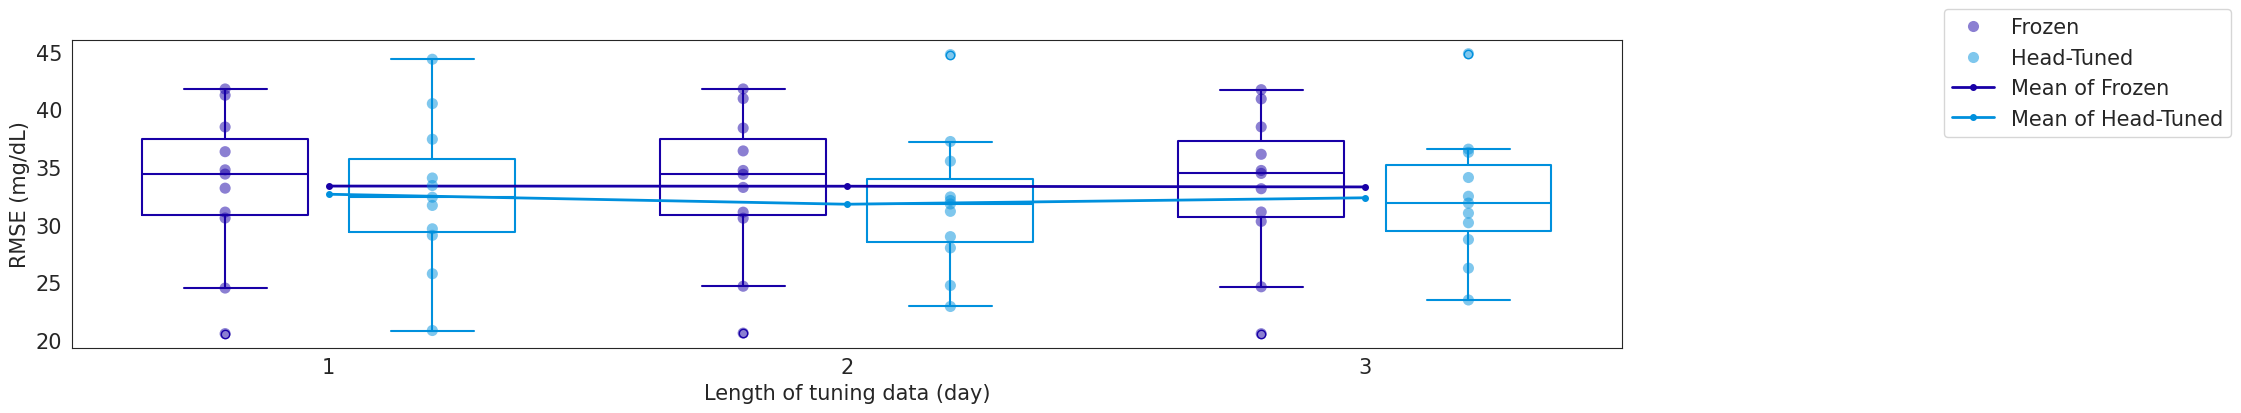

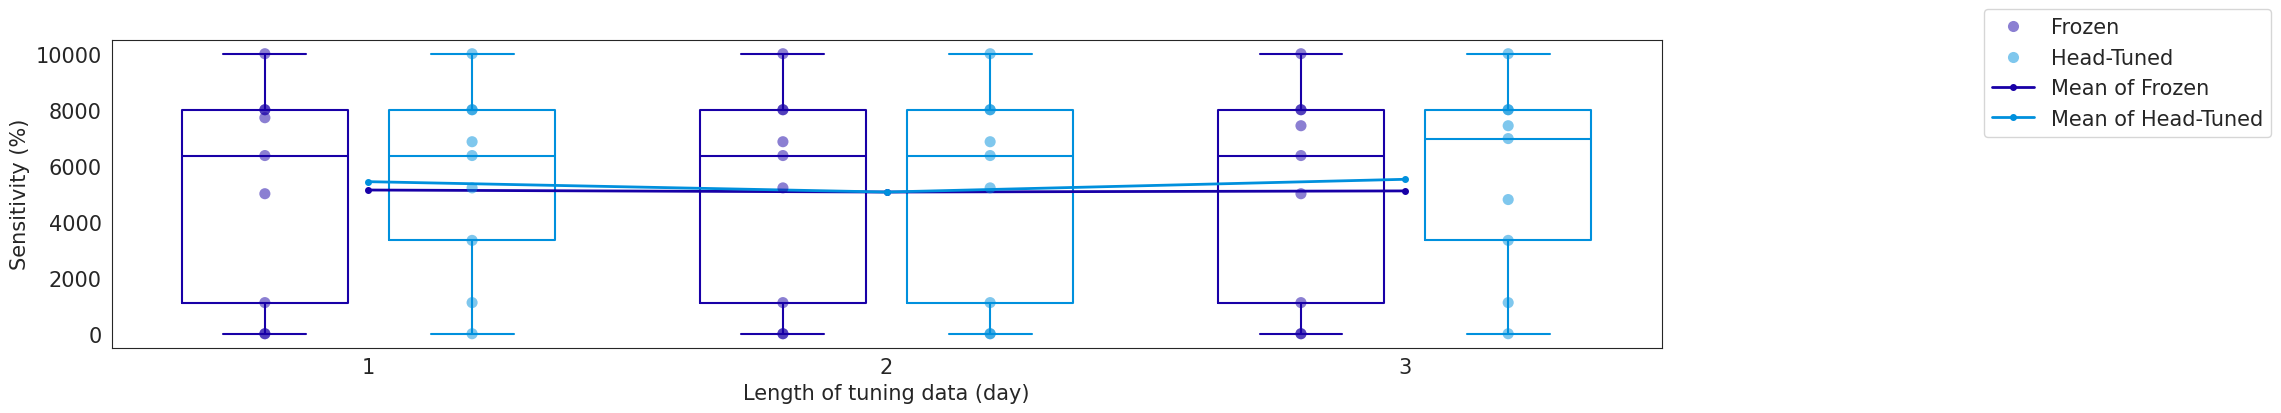

In [16]:
unique_ft_types= ['Frozen', 'Head-Tuned']
unique_cl_types= ['EWC21']

fig_data = all_results_reg[all_results_reg.FT_Type.isin(unique_ft_types) & all_results_reg.CL_Type.isin(unique_cl_types)]
fig_nohypo_data = all_results_clf[all_results_clf.FT_Type.isin(unique_ft_types) & all_results_clf.CL_Type.isin(unique_cl_types)]


plt.rc('font', size=15)

sns.set_style('white')
pal = sns.color_palette('nipy_spectral')
dark_pal = [darken_color(color) for color in pal]

'''
RMSE
'''
plt.figure(figsize = (20, 4))
sns.stripplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, legend=False)
grouped = fig_data.groupby(['Tune_length', 'FT_Type']).agg({'RMSE': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['RMSE']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)

# plt.title(f"Comparison of RMSE with increasing tuning data length")
plt.xlabel('Length of tuning data (day)')
plt.ylabel('RMSE (mg/dL)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))
plt.show()

'''
Sensitivity
'''
plt.figure(figsize = (20, 4))
sns.stripplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, showfliers=False, legend=False)

grouped = fig_nohypo_data.groupby(['Tune_length', 'FT_Type']).agg({'Sensitivity': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['Sensitivity']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)
plt.xlabel('Length of tuning data (day)')
plt.ylabel('Sensitivity (%)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))

# plt.title(f"Comparison of Sensitivity with increasing tuning data length")
plt.show()           

# Figure. Tuning Duration

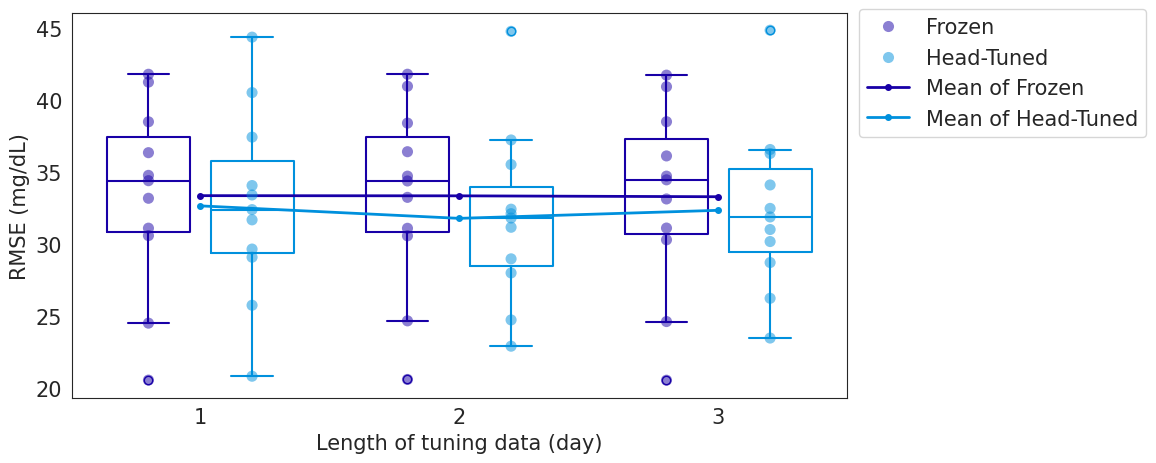

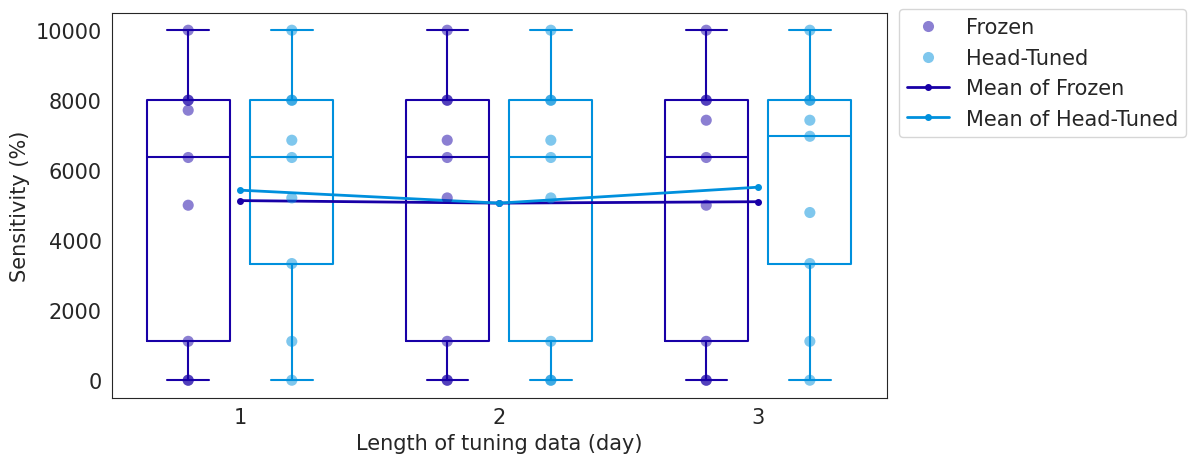

In [17]:
unique_ft_types= ['Frozen', 'Head-Tuned']
unique_cl_types= ['EWC21']

fig_data = all_results_reg[all_results_reg.FT_Type.isin(unique_ft_types) & all_results_reg.CL_Type.isin(unique_cl_types)]
fig_nohypo_data = all_results_clf[all_results_clf.FT_Type.isin(unique_ft_types) & all_results_clf.CL_Type.isin(unique_cl_types)]


plt.rc('font', size=15)

sns.set_style('white')
pal = sns.color_palette('nipy_spectral')
dark_pal = [darken_color(color) for color in pal]

'''
RMSE
'''
plt.figure(figsize = (10, 5))
sns.stripplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='RMSE', hue='FT_Type', data=fig_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, legend=False)
grouped = fig_data.groupby(['Tune_length', 'FT_Type']).agg({'RMSE': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['RMSE']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)

# plt.title(f"Comparison of RMSE with increasing tuning data length")
plt.xlabel('Length of tuning data (day)')
plt.ylabel('RMSE (mg/dL)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))
plt.show()

'''
Sensitivity
'''
plt.figure(figsize = (10, 5))
sns.stripplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, jitter=False, dodge=True, palette=pal, alpha = 0.5, size = 8)
sns.boxplot(x='Tune_length', y='Sensitivity', hue='FT_Type', data=fig_nohypo_data, palette=pal, dodge=True, width=0.8, fill=False, gap=.2, showfliers=False, legend=False)

grouped = fig_nohypo_data.groupby(['Tune_length', 'FT_Type']).agg({'Sensitivity': ['mean', 'std']}).reset_index()
for i,ft_type in enumerate(unique_ft_types):
    subset = grouped[grouped['FT_Type'] == ft_type]
    plt.plot(subset['Tune_length']-1, subset['Sensitivity']['mean'], label=f'Mean of {ft_type}', color=pal[i], marker='o', linestyle='-', linewidth=2, markersize=4)
plt.xlabel('Length of tuning data (day)')
plt.ylabel('Sensitivity (%)')
plt.legend(loc='lower right', bbox_to_anchor=(1.40,0.65))

# plt.title(f"Comparison of Sensitivity with increasing tuning data length")
plt.show()           

# Mean (Std) of All Datasets

## PH30

In [24]:
r1 = pd.read_csv('Results/Performance_sub/Table_DiaTrend_PH30.csv', index_col=0); r1['dataset'] = 'DiaTrend';
r2 = pd.read_csv('Results/Performance_sub/Table_OhioT1DM_PH30.csv', index_col=0); r2['dataset'] = 'OhioT1DM';
r3 = pd.read_csv('Results/Performance_sub/Table_ShanghaiT1DM_PH30.csv', index_col=0); r3['dataset'] = 'ShanghaiT1DM';
r_30 = pd.concat([r1,r2,r3])

print(f"Real World Result -- Frozen & PH30")
r = r_30[(r_30.FT_Type == 'Frozen') & (r_30.CL_Type == 'EWC21') & (r_30.Tune_length==3)]
print(f"RMSE: {r.RMSE.mean():.2f} ({r.RMSE.std():.2f})")
print(f"MAE: {r.MAE.mean():.2f} ({r.MAE.std():.2f})")
r_containhypo = r[r.N_hypo!=0]
print(f"RMSE: {r_containhypo.Sensitivity.mean():.2f} ({r_containhypo.Sensitivity.std():.2f})")
print(f"MAE: {r_containhypo.Specificity.mean():.2f} ({r_containhypo.Specificity.std():.2f})")

print(f"Real World Result -- Head-Tuned & PH30")
r = r_30[(r_30.FT_Type == 'Head-Tuned') & (r_30.CL_Type == 'EWC21') & (r_30.Tune_length==3)]
print(f"RMSE: {r.RMSE.mean():.2f} ({r.RMSE.std():.2f})")
print(f"MAE: {r.MAE.mean():.2f} ({r.MAE.std():.2f})")
r_containhypo = r[r.N_hypo!=0]
print(f"Sens: {r_containhypo.Sensitivity.mean():.2f} ({r_containhypo.Sensitivity.std():.2f})")
print(f"Spec: {r_containhypo.Specificity.mean():.2f} ({r_containhypo.Specificity.std():.2f})")

Real World Result -- Frozen & PH30
RMSE: 15.05 (3.84)
MAE: 10.65 (2.51)
RMSE: 85.72 (10.58)
MAE: 94.07 (2.61)
Real World Result -- Head-Tuned & PH30
RMSE: 15.00 (3.80)
MAE: 10.76 (2.71)
Sens: 85.56 (10.51)
Spec: 94.09 (2.57)


## PH60

In [17]:
r1 = pd.read_csv('Results/Performance_sub/Table_DiaTrend_PH60.csv', index_col=0); r1['dataset'] = 'DiaTrend';
r2 = pd.read_csv('Results/Performance_sub/Table_OhioT1DM_PH60.csv', index_col=0); r2['dataset'] = 'OhioT1DM';
r3 = pd.read_csv('Results/Performance_sub/Table_ShanghaiT1DM_PH60.csv', index_col=0); r3['dataset'] = 'ShanghaiT1DM';
r_30 = pd.concat([r1,r2,r3])

print(f"Real World Result -- Frozen & PH60")
r = r_30[(r_30.FT_Type == 'Frozen') & (r_30.CL_Type == 'EWC21') & (r_30.Tune_length==3)]
print(f"RMSE: {r.RMSE.mean():.2f} ({r.RMSE.std():.2f})")
print(f"MAE: {r.MAE.mean():.2f} ({r.MAE.std():.2f})")
# print(f"Sens: {r.Sensitivity.mean():.2f} ({r.Sensitivity.std():.2f})")
# print(f"Spec: {r.Specificity.mean():.2f} ({r.Specificity.std():.2f})")

print(f"Real World Result -- Head-Tuned & PH60")
r = r_30[(r_30.FT_Type == 'Head-Tuned') & (r_30.CL_Type == 'EWC21') & (r_30.Tune_length==3)]
print(f"RMSE: {r.RMSE.mean():.2f} ({r.RMSE.std():.2f})")
print(f"MAE: {r.MAE.mean():.2f} ({r.MAE.std():.2f})")
# print(f"Sens: {r.Sensitivity.mean():.2f} ({r.Sensitivity.std():.2f})")
# print(f"Spec: {r.Specificity.mean():.2f} ({r.Specificity.std():.2f})")

Real World Result -- Frozen & PH60
RMSE: 33.94 (7.44)
MAE: 25.65 (5.79)
Real World Result -- Head-Tuned & PH60
RMSE: 31.01 (7.80)
MAE: 22.77 (5.87)
